In [1]:
from transforms import *
from torchvision.transforms import *
import librosa
import utils.config as config
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from functools import partial
from datasets.librispeech import convert_to_mel
import soundfile
import resampy

def tensor_to_img(spectrogram):
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(spectrogram, x_axis='time', y_axis='mel')
    plt.colorbar()
    plt.tight_layout()

2020-01-07 08:05:37 - INFO - dataset_scripts/sp_librispeech_128.model has been loaded!


In [2]:
# audio_path = '/Users/audio.wav'
audio_path = '/Users/vigi99/AirtelDEV/VoiceDataForAirtel/testset-backup-paymentbank-validation/validation_payments_clips/7e59457a-0dc1-49a2-89af-cfb4e66dcf19/2ca801a0c0f02b4c664eaab7ab9aa111eec4c1fcf89af8c1a2b7d0a1399e237d.wav'
audio, original_sampling_rate = soundfile.read(audio_path, dtype='float32')
audio = resampy.resample(audio, 16000, original_sampling_rate, axis=-1)
# audio, _ = librosa.core.load(audio_path, sr=16000)
data = {'samples': audio, 'sample_rate': config.sampling_rate, 'epoch': 0}

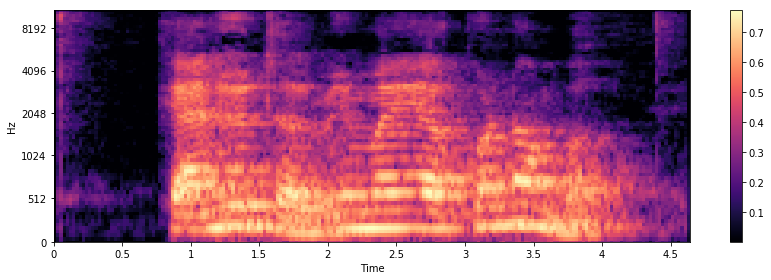

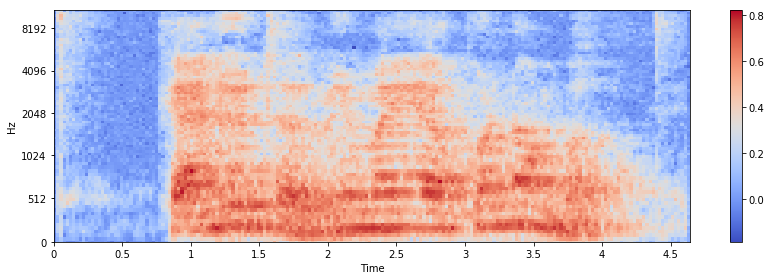

In [3]:
def get_mel(audio):
    return convert_to_mel(audio.reshape(1, -1))

def image_train_transform(mel_spec, epoch=int(config.augment_warmup_epoch * 1.0)):
    data = {'mel_spectrogram': mel_spec, 'sample_rate': config.sampling_rate, 'epoch': epoch}
    transforms = Compose([SpecNoise(), ToAudioTensor(['mel_spectrogram'])])
    return transforms(data)

spec_dctts_orig = get_mel(audio)
tensor_to_img(spec_dctts_orig)
spec_dctts_modified = image_train_transform(spec_dctts_orig)
tensor_to_img(spec_dctts_modified)

In [16]:
def blur_signal(signal):
    data = {'samples': signal, 'sample_rate': config.sampling_rate, 'epoch': 100}
    to_stft = ToSTFT(n_fft=config.n_fft, hop_length=config.hop_length, win_length=config.window_length)
    transforms = Compose([to_stft, SpecSprinkleOnMel(type='stft'), ToAudioTensor(['stft'])])
    blurred_spec = transforms(data)
    blurred_signal = librosa.core.istft(blurred_spec, hop_length=config.hop_length, win_length=config.window_length)
    return blurred_signal

In [17]:
import IPython.display as ipd
ipd.Audio(audio, rate=config.sampling_rate)

In [18]:
blurred_signal = blur_signal(audio)
ipd.Audio(blurred_signal, rate=config.sampling_rate)

Total params: 38.13M


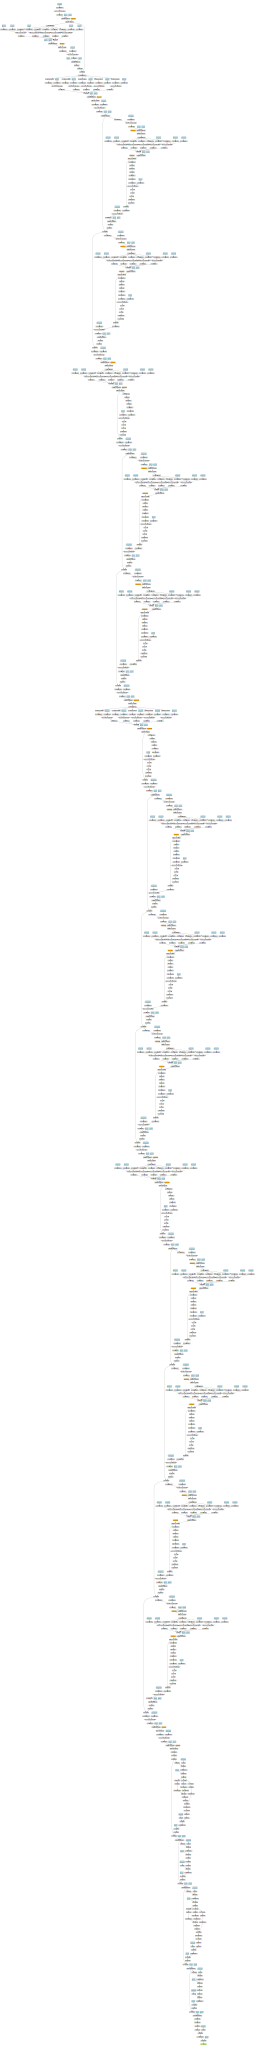

In [1]:
import torch
from torchviz import make_dot
from models.mixnet import ASRModel
from utils import config
net = ASRModel(input_features=80, num_classes=128)
print('Total params: %.2fM' % (sum(p.numel() for p in net.parameters())/1000000.0))
image = torch.randn(1, 80, 500)
y = net(image)
make_dot(y)